In [2]:
!pip install pytorch-tabnet wget

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Load dataset

In [3]:
df = pd.read_csv('DNN-EdgeIIoT-dataset.csv', low_memory=False)

drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 

         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",

         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",

         "tcp.dstport", "udp.port", "mqtt.msg"]

df.drop(drop_columns, axis=1, inplace=True)

df.dropna(axis=0, how='any', inplace=True)

df.drop_duplicates(subset=None, keep="first", inplace=True)

df = shuffle(df)

# Load data and split
Same split as in original paper

In [4]:
#split data
X = df.iloc[:,0:46]
#for binary class
Y_B = df.iloc[:,46]
#for multiclass 
Y = df.iloc[:,47]
print(Y.unique())

#remove one of the types
df.pop("Attack_type")
# split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
n_total = len(df)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

['DDoS_ICMP' 'Normal' 'DDoS_UDP' 'Backdoor' 'DDoS_TCP' 'DDoS_HTTP'
 'Ransomware' 'Vulnerability_scanner' 'SQL_injection' 'Password' 'XSS'
 'Port_Scanning' 'Uploading' 'Fingerprinting' 'MITM']


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [5]:
categorical_columns = []
categorical_dims =  {}
for col in df.columns[df.dtypes == object]:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    df[col] = l_enc.fit_transform(df[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

http.request.method 9
http.referer 5
http.request.version 13
dns.qry.name.len 10
mqtt.conack.flags 13
mqtt.protoname 3
mqtt.topic 3


# Define categorical features for categorical embeddings

In [6]:
unused_feat = []

features = [ col for col in df.columns if col not in unused_feat+["Attack_label"]+["Attack_type"]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

print(features)


['arp.opcode', 'arp.hw.size', 'icmp.checksum', 'icmp.seq_le', 'icmp.unused', 'http.content_length', 'http.request.method', 'http.referer', 'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.seq', 'udp.stream', 'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.conack.flags', 'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.protoname', 'mqtt.topic', 'mqtt.topic_len', 'mqtt.ver', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id']


# Network parameters

In [7]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95, "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Training

In [8]:
X_train = df[features].values[train_indices]
y_train = df["Attack_label"].values[train_indices]

X_valid = df[features].values[valid_indices]
y_valid = df["Attack_label"].values[valid_indices]

X_test = df[features].values[test_indices]
y_test = df["Attack_label"].values[test_indices]

max_epochs = 5 if not os.getenv("CI", False) else 2

In [57]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256
) 

epoch 0  | loss: 0.04435 | train_auc: 1.0     | valid_auc: 1.0     |  0:08:42s
epoch 1  | loss: 8e-05   | train_auc: 1.0     | valid_auc: 1.0     |  0:17:23s
epoch 2  | loss: 9e-05   | train_auc: 0.99999 | valid_auc: 1.0     |  0:26:17s
epoch 3  | loss: 4e-05   | train_auc: 1.0     | valid_auc: 1.0     |  0:34:53s
epoch 4  | loss: 4e-05   | train_auc: 0.99999 | valid_auc: 1.0     |  0:43:22s
Stop training because you reached max_epochs = 5 with best_epoch = 0 and best_valid_auc = 1.0


/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


{'loss': [0.04435157315592441, 7.635804614701849e-05, 8.955612928172829e-05, 4.4639235643591104e-05, 3.8085200832292974e-05], 'lr': [0.02, 0.02, 0.02, 0.02, 0.02], 'train_auc': [0.999998776754745, 0.9999999996029483, 0.9999935874455645, 0.9999954700400017, 0.9999924551393194], 'valid_auc': [1.0, 1.0, 0.9999978641346524, 0.9999981885869871, 0.9999966454720052]}


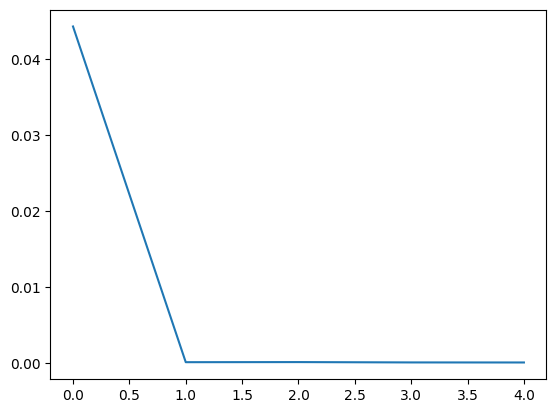

In [66]:
# plot losses
plt.plot(clf.history['loss'])

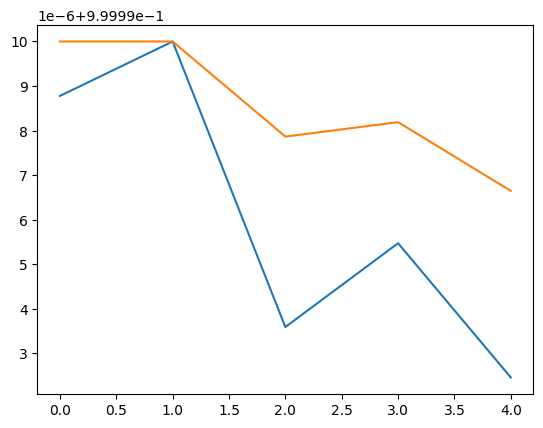

In [69]:
# plot accuracy
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

### Predictions


In [70]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_acc}")

BEST VALID SCORE FOR : 1.0
FINAL TEST SCORE FOR : 0.9906319138073232


In [71]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR : {test_acc}")

FINAL TEST SCORE FOR : 0.9906319138073232


# Save and load Model

In [73]:
# save state dict
saved_filename = clf.save_model('modelEdgeIIot')

Successfully saved model at modelEdgeIIot.zip


In [74]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

/Users/melicias/.local/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [76]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR : {loaded_test_acc}")

FINAL TEST SCORE FOR : 0.9906319138073232


In [77]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [78]:
clf.feature_importances_

array([2.31601670e-03, 1.67525466e-02, 1.08654501e-04, 2.45257012e-02,
       2.57284248e-02, 5.57765652e-03, 1.25317855e-02, 2.07475214e-02,
       1.54625466e-02, 1.72611731e-04, 5.73985838e-04, 9.08662566e-03,
       7.46285898e-02, 8.24713175e-03, 7.56580650e-03, 5.09950190e-04,
       2.00394507e-03, 6.06427893e-05, 1.64948900e-02, 3.41376827e-04,
       3.25770508e-04, 2.25506702e-02, 4.02954696e-02, 7.59187873e-04,
       4.93055612e-03, 5.89554875e-03, 5.25766079e-03, 2.82469754e-03,
       7.67062547e-03, 7.58715557e-07, 3.91078170e-04, 2.15000513e-01,
       3.98141898e-03, 1.18730920e-02, 1.34433071e-01, 2.44997955e-05,
       6.07278436e-04, 1.21351783e-02, 1.23436930e-02, 1.62634560e-01,
       2.87873231e-02, 2.14294691e-02, 4.90241424e-02, 1.13514056e-02,
       9.43265323e-05, 1.94159591e-03])

# Local explainability and masks

In [18]:
explain_matrix, masks = clf.explain(X_test)

NameError: name 'clf' is not defined

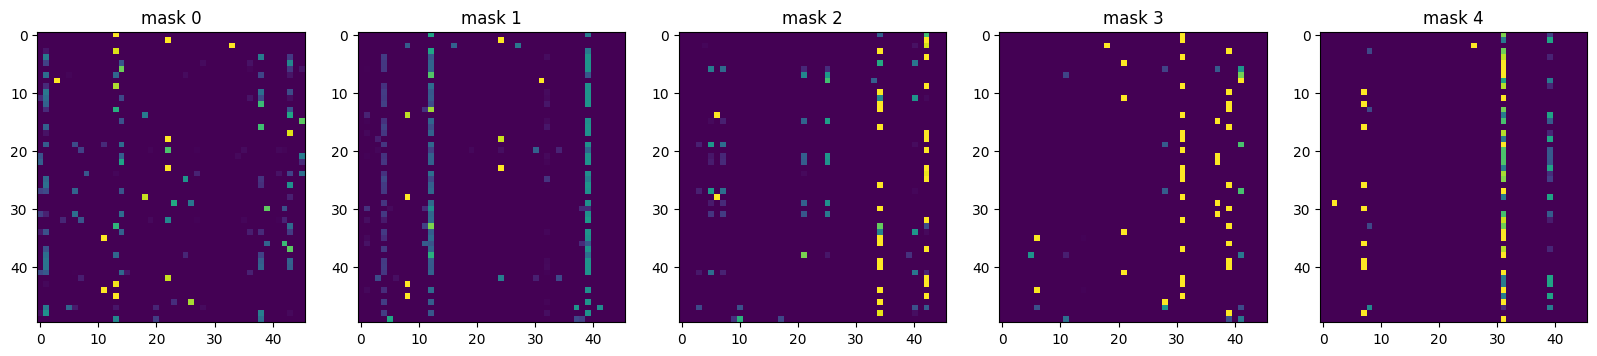

In [80]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [9]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [10]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    num_class= len(Y.unique()))
le = LabelEncoder()
y_valid = le.fit_transform(y_valid)
clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

: 

: 

In [4]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)

NameError: name 'clf_xgb' is not defined